In [1]:
import numpy as np

from IPython.display import display
from PIL import Image
from peewee import IntegerField, Model, CharField, SqliteDatabase, AutoField
import matplotlib.pyplot as plt

db = SqliteDatabase('events-testing.db')


class Events(Model):
    id = AutoField()
    time = IntegerField()
    agent = CharField()
    event = CharField()
    participant_id = IntegerField()
    old_value = CharField(null=True)
    new_value = CharField(null=True)
    screenshot_file = CharField(null=True)

    class Meta:
        database = db

def show_screenshot_for_record(_id):
    events = Events.select().where(Events.id == _id).order_by(Events.time.asc()).limit(1)
    if len(events) == 0:
        print("No events found for id: ", _id)
        return
    event = events[0]
    image_path = event.screenshot_file
    print(_id)
    display(Image.open(image_path))


2 1702463997098 USER OPEN_BOOK 999 None Chasing Sunsets -  screenshots/8add516e-0f80-448f-9d9e-80a6e4d66445.png
3 1702464004978 USER NEXT_PAGE 999 None None screenshots/ff6cbb0d-2dde-417f-b9c0-60f7f23c29d6.png
4 1702464008095 USER SET_TYPOGRAPHY_FONTWEIGHT 999 100 400 screenshots/2c726ba8-6d44-416c-89c7-04af2a55aa45.png
5 1702464010182 USER SET_TYPOGRAPHY_FONTSIZE 999 14 18 screenshots/1f8eb2f6-e9b5-4192-9ddf-efc9e7cb36ba.png
6 1702464011519 USER SET_TYPOGRAPHY_FONTSIZE 999 18 14 screenshots/7d56045e-392e-4631-a14a-abea1ab5aa9e.png
7 1702464014415 USER SET_TYPOGRAPHY_FONTSIZE 999 14 18 screenshots/71f29697-88b5-4c56-a80c-4551c56e846c.png
8 1702464039191 USER NEXT_PAGE 999 None None screenshots/05f8bffd-215b-44d2-98ec-d634eabe7f5f.png
9 1702464062402 USER NEXT_PAGE 999 None None screenshots/e1cc7135-22d8-46bd-9e79-17efe53fef96.png
10 1702464074587 USER NEXT_PAGE 999 None None screenshots/870b4634-6d1f-4565-b9c8-6cdac40264d6.png
13 1702464076659 USER NEXT_PAGE 999 None None screenshots/6

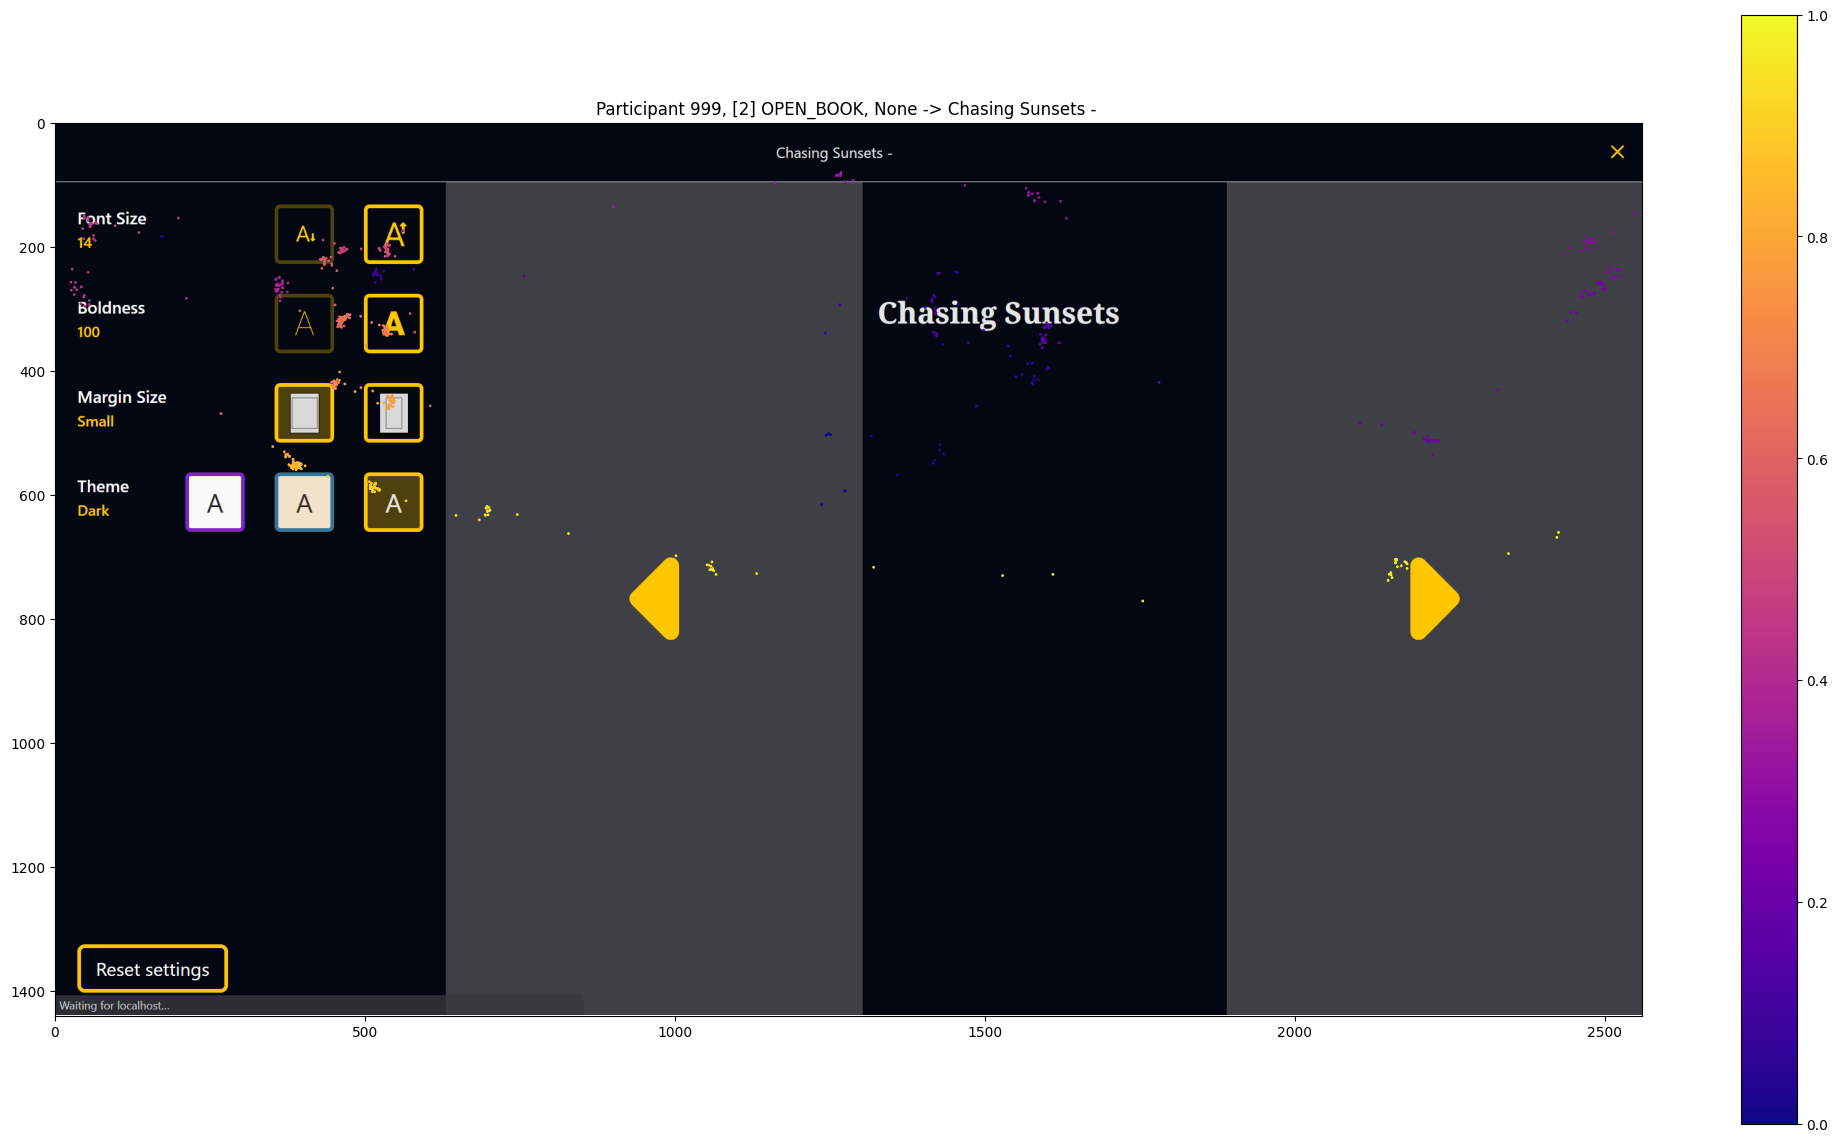

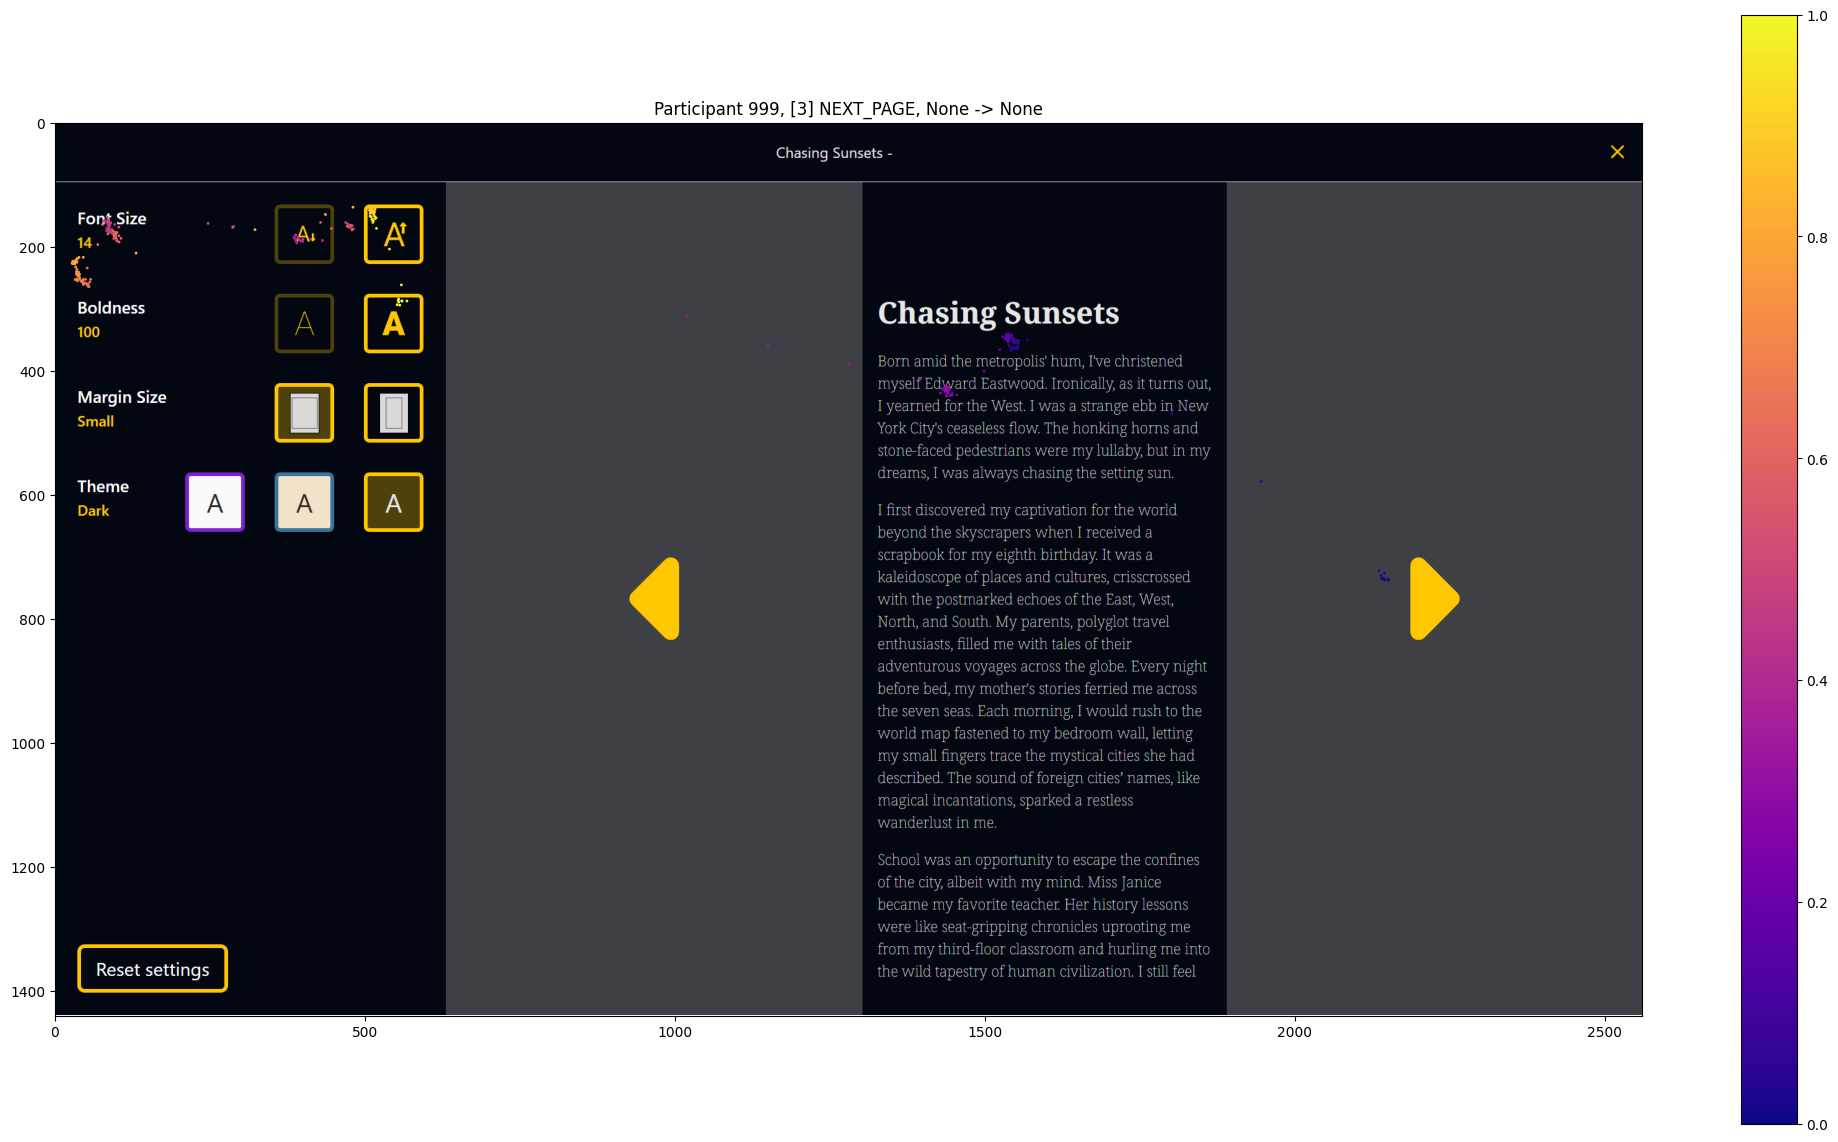

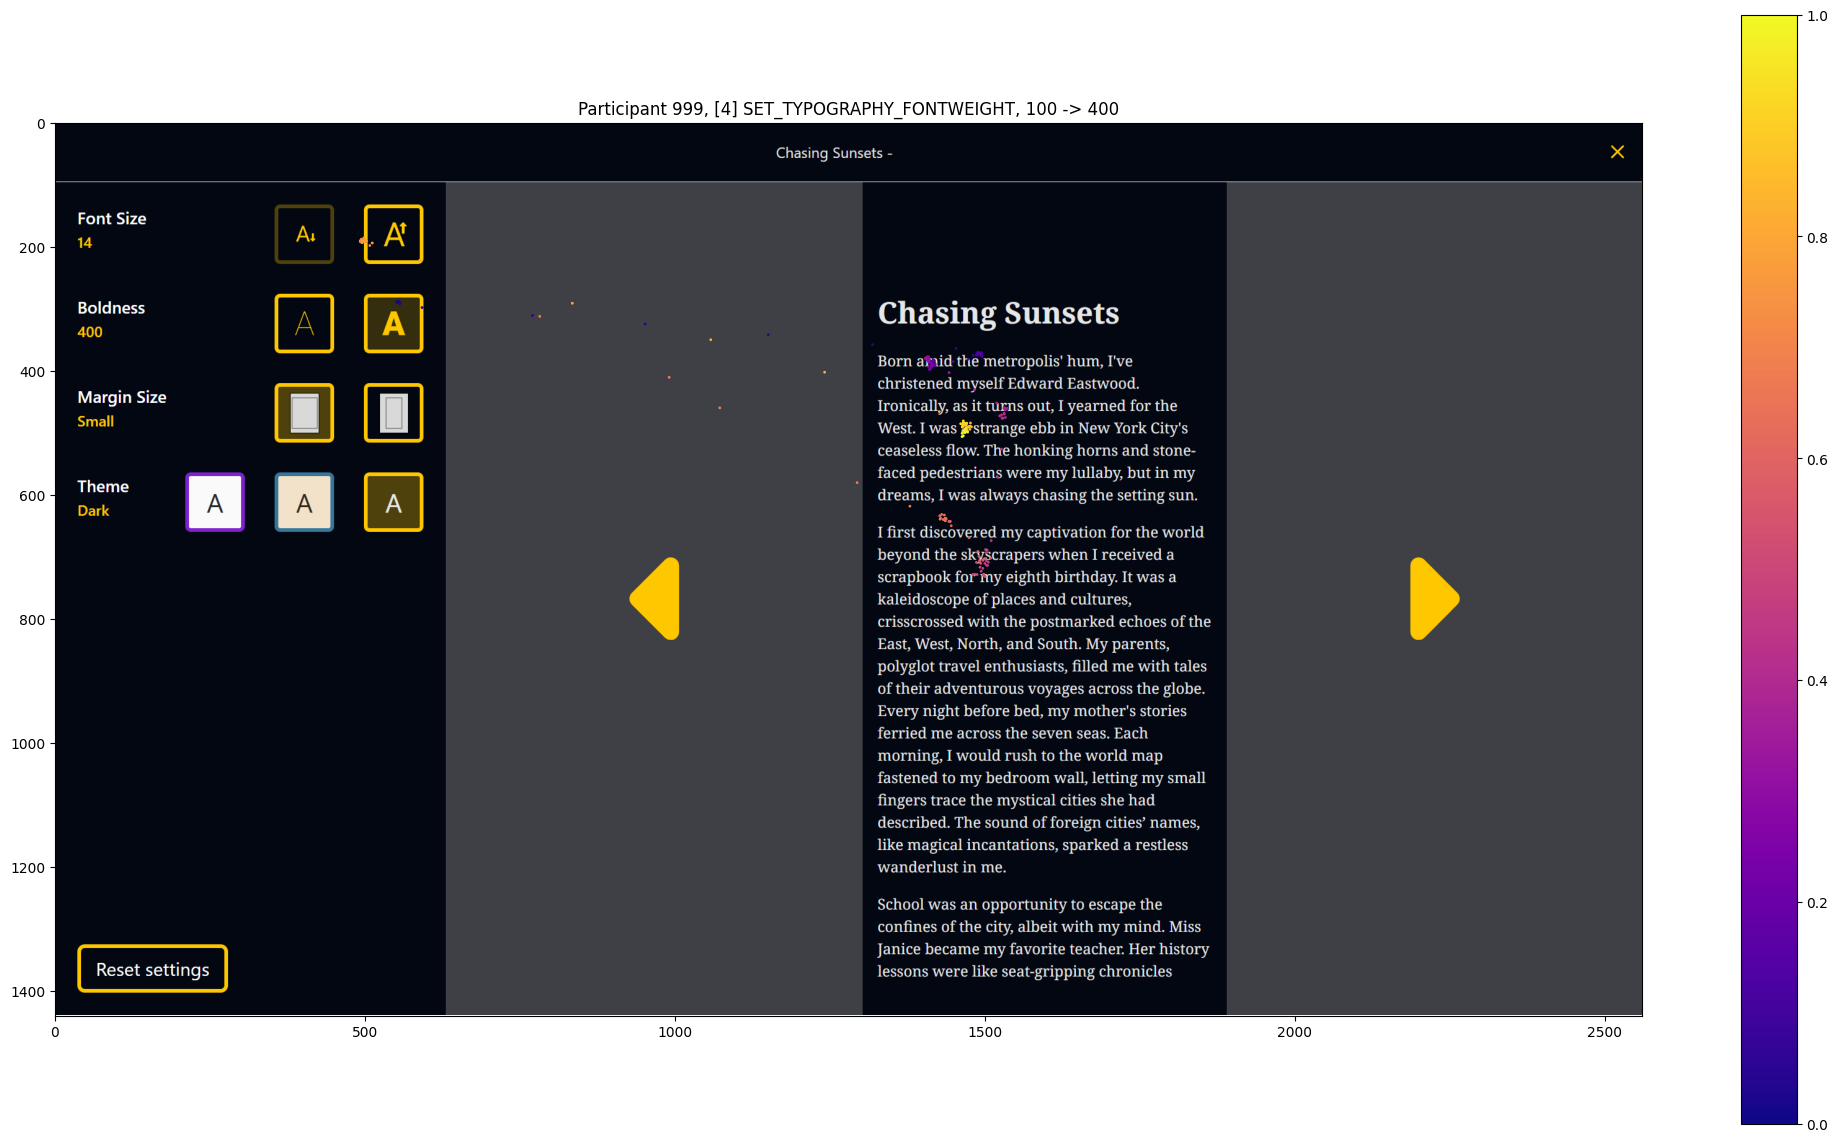

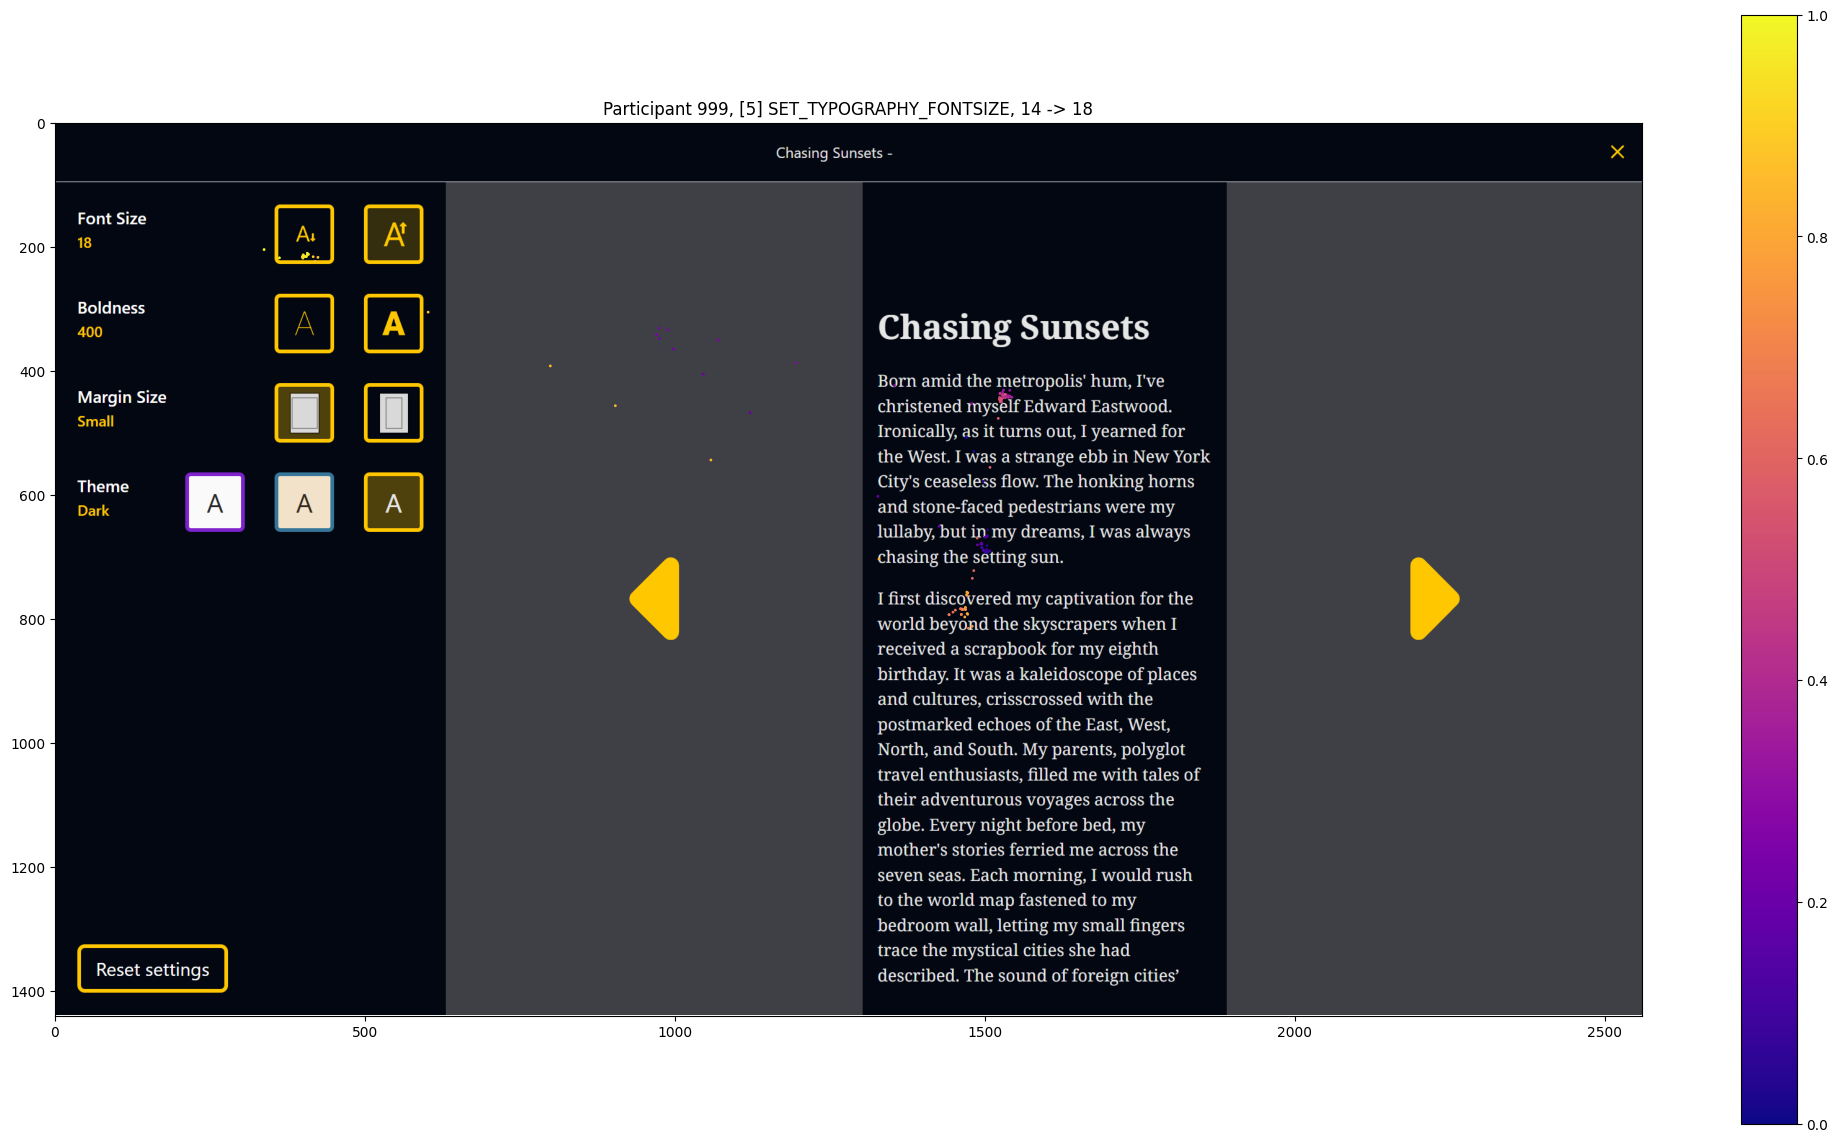

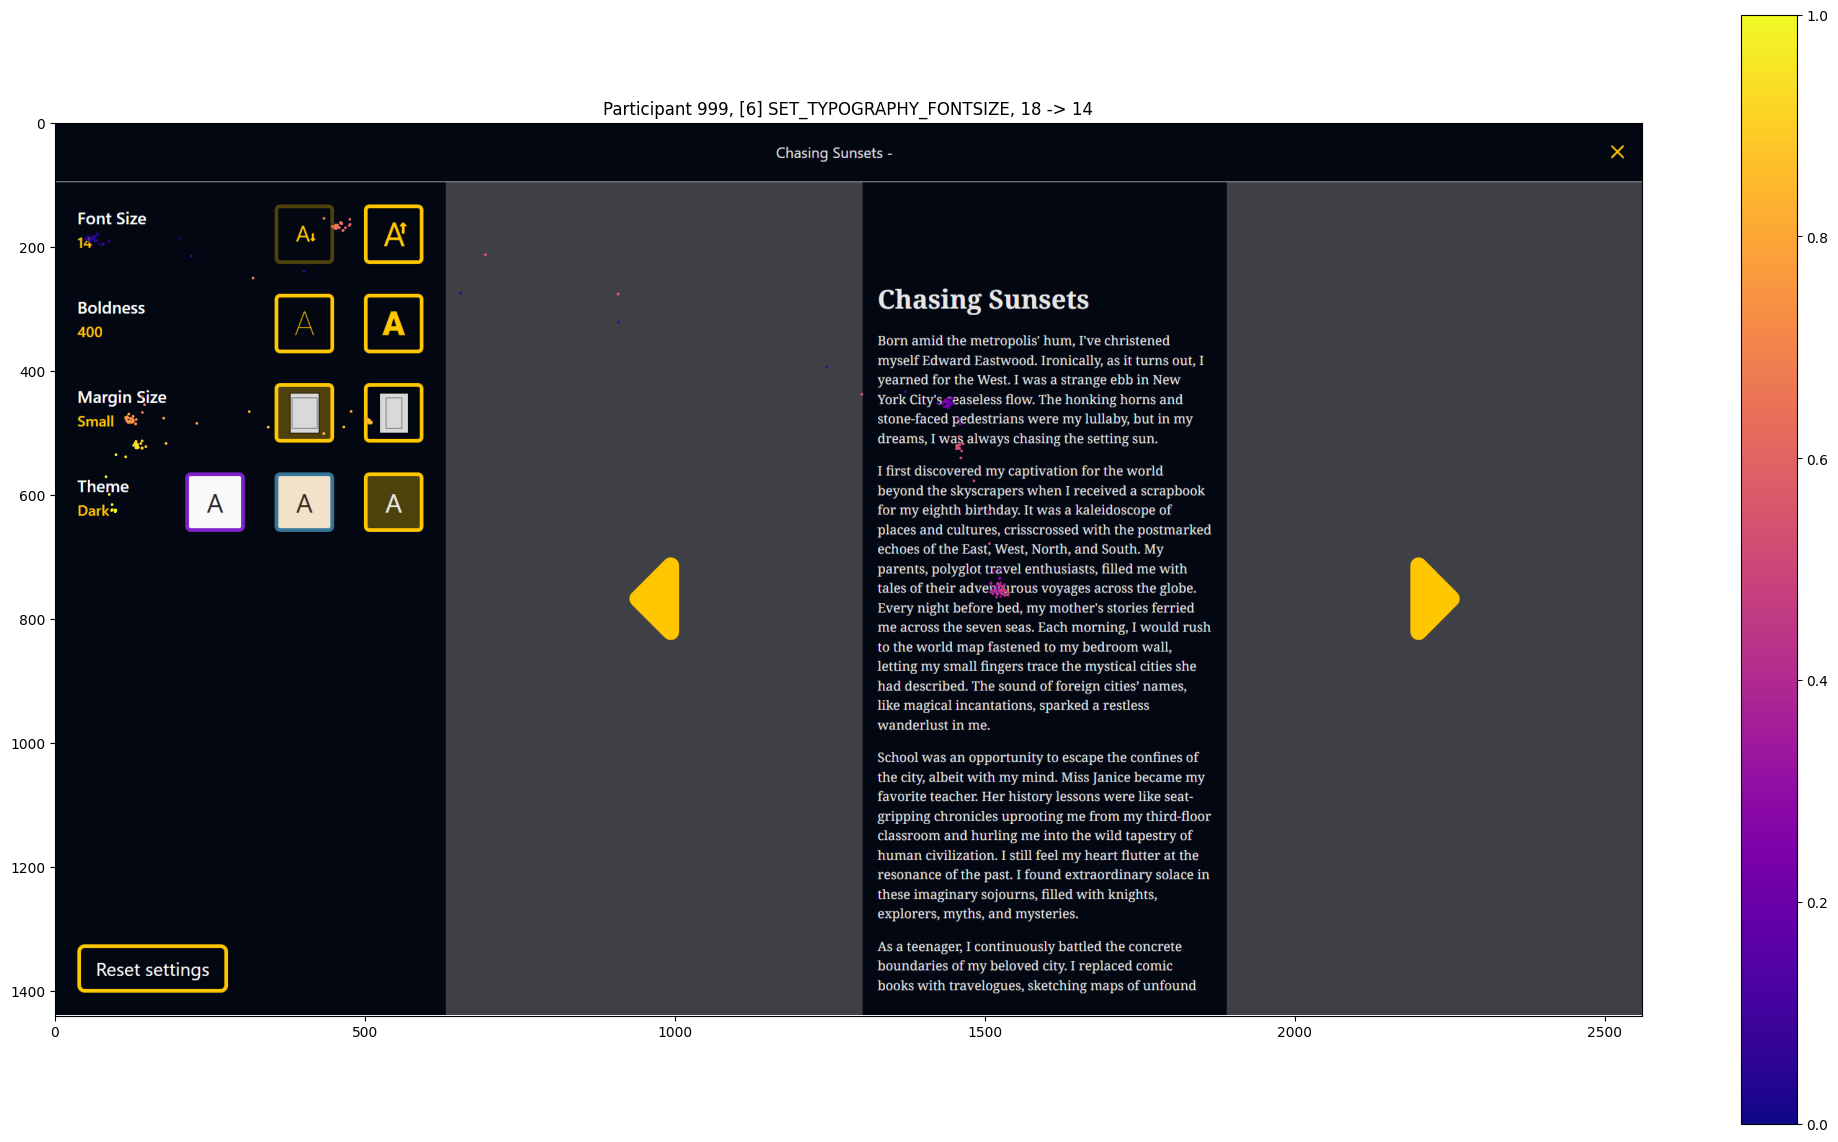

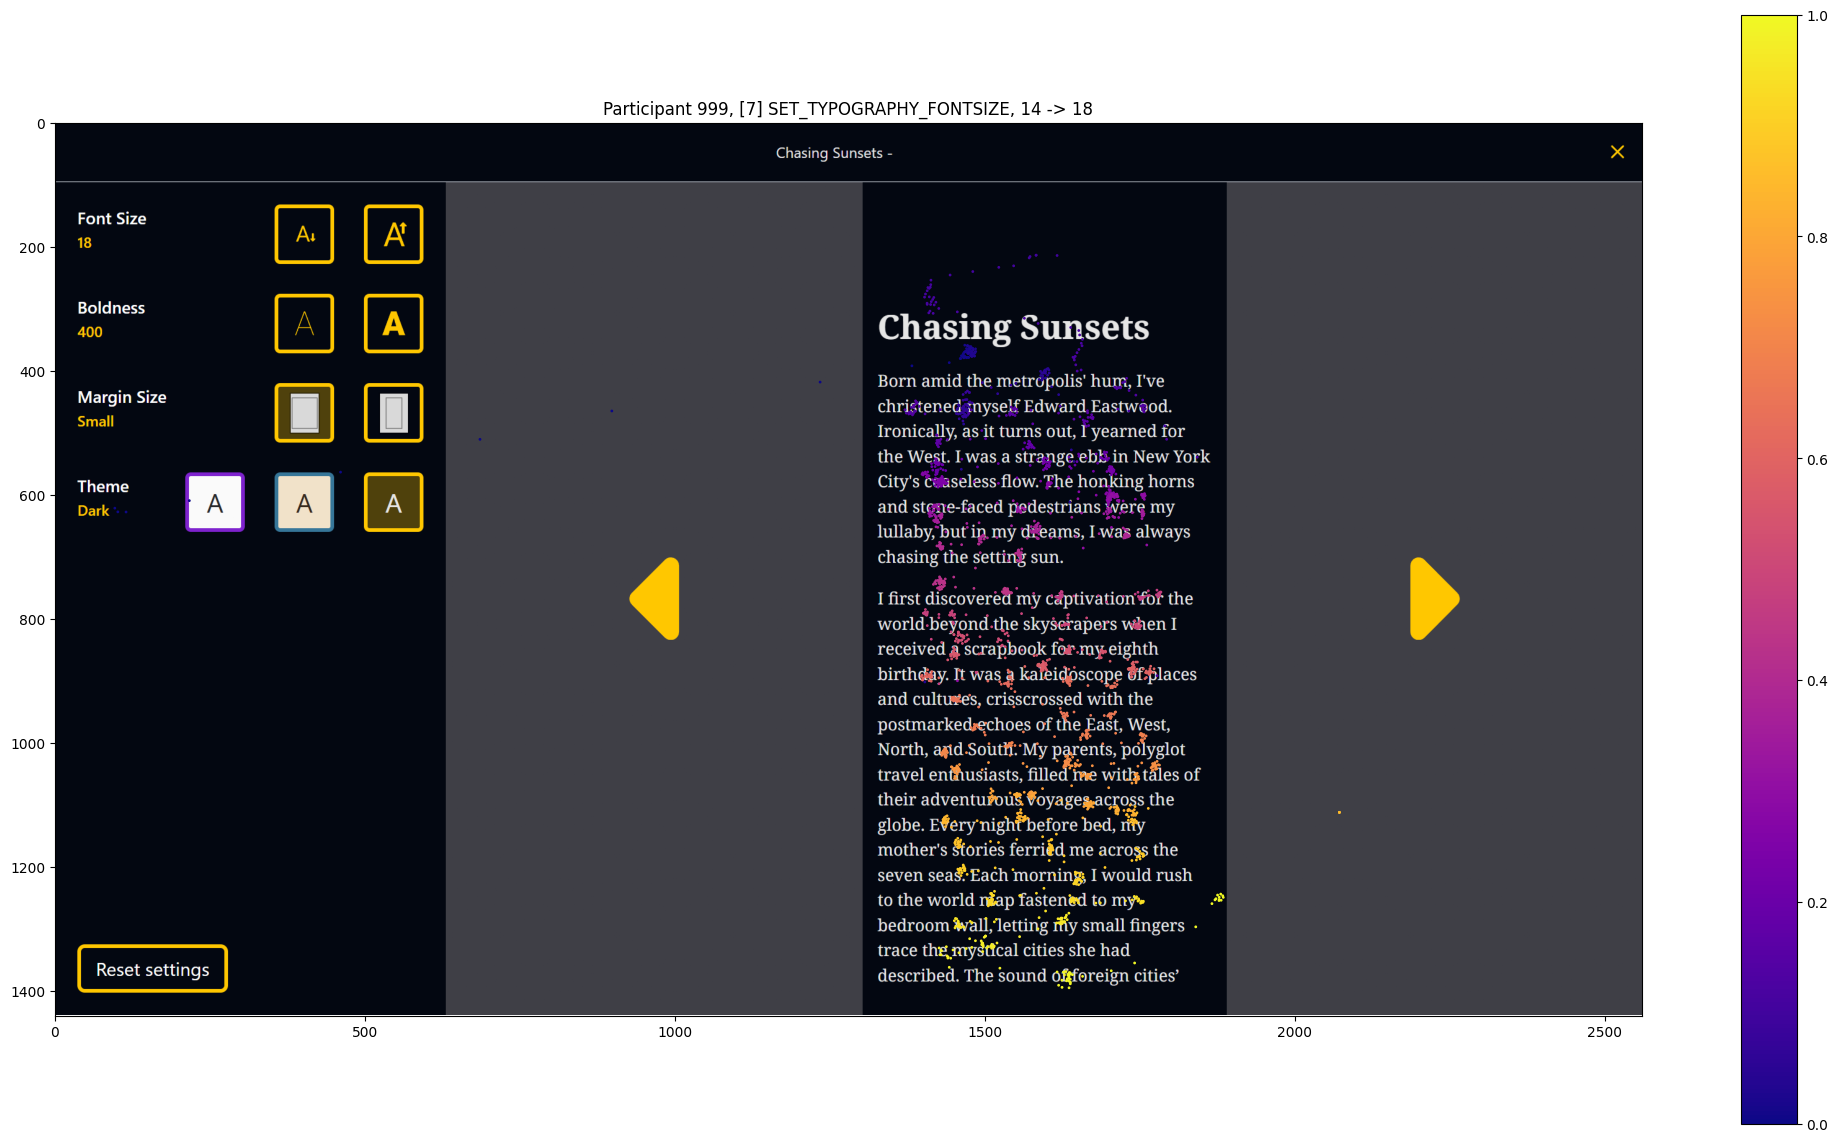

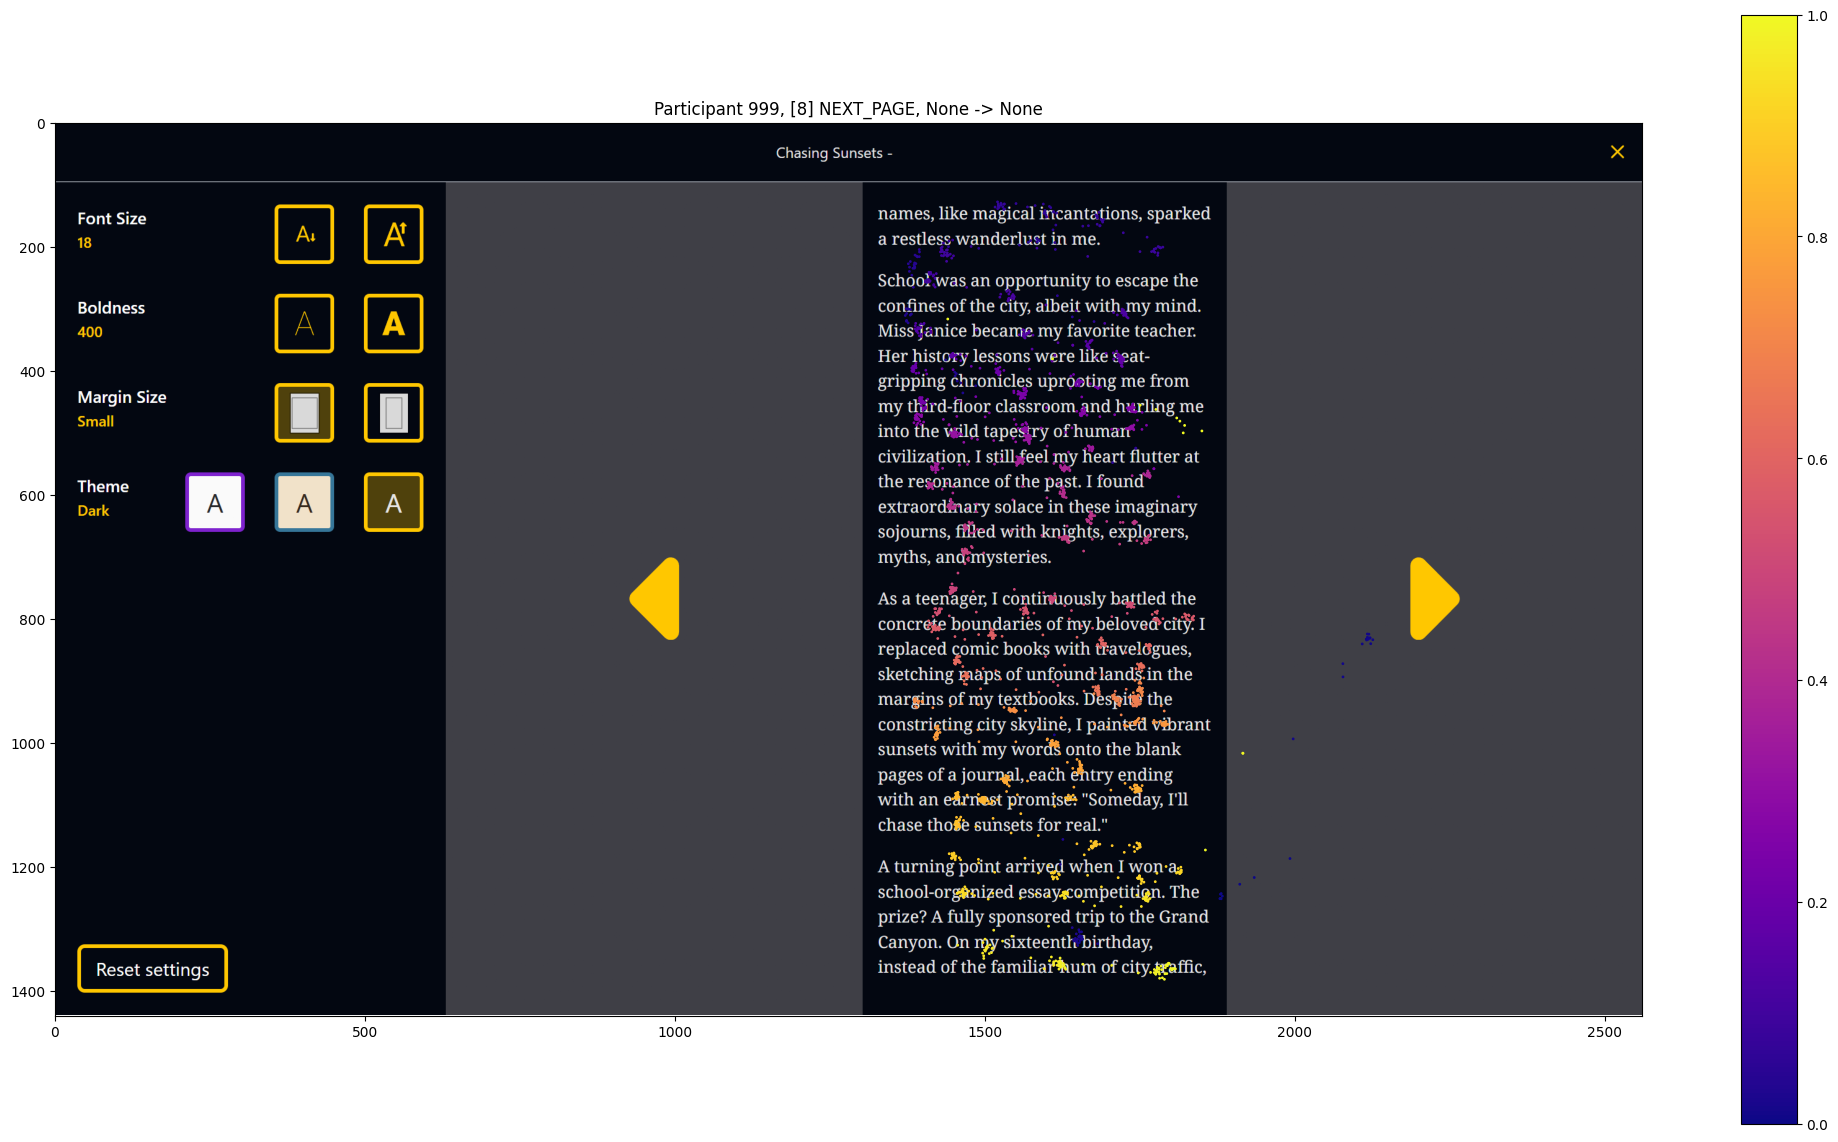

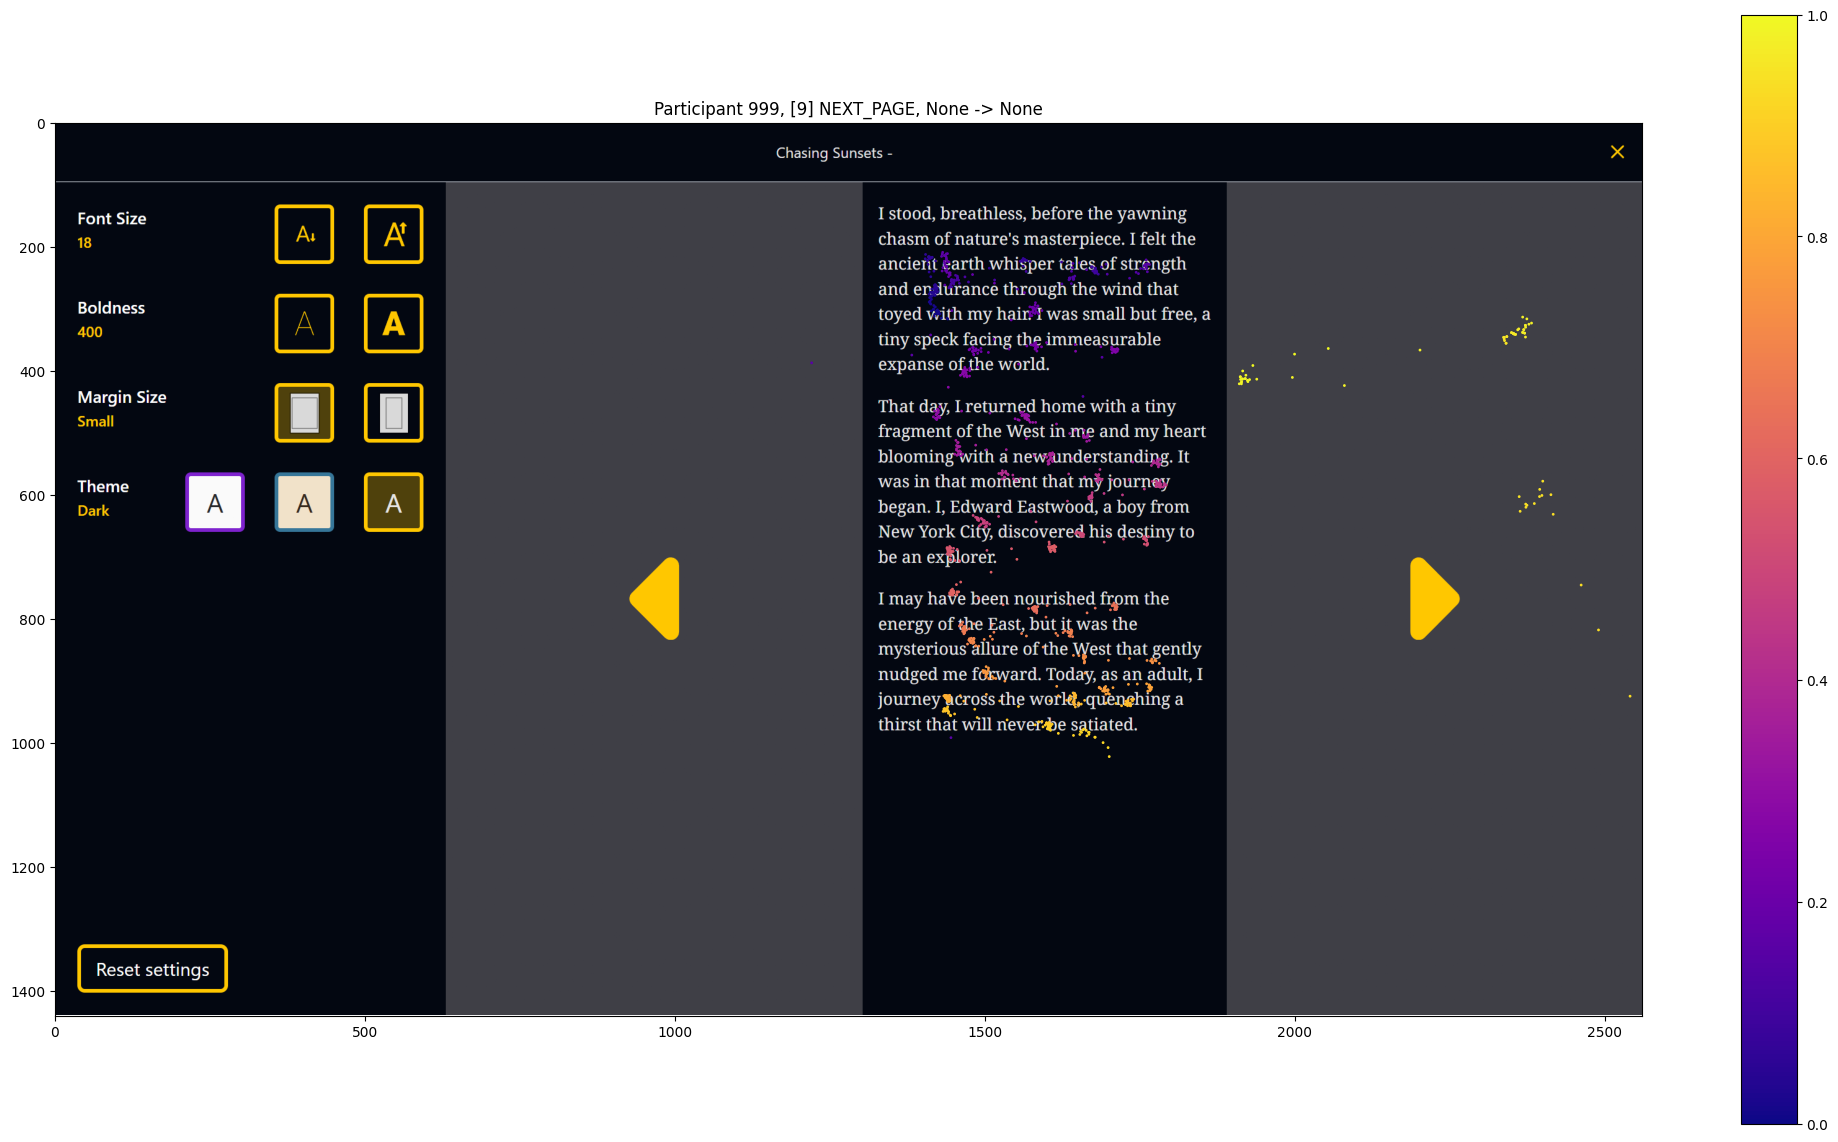

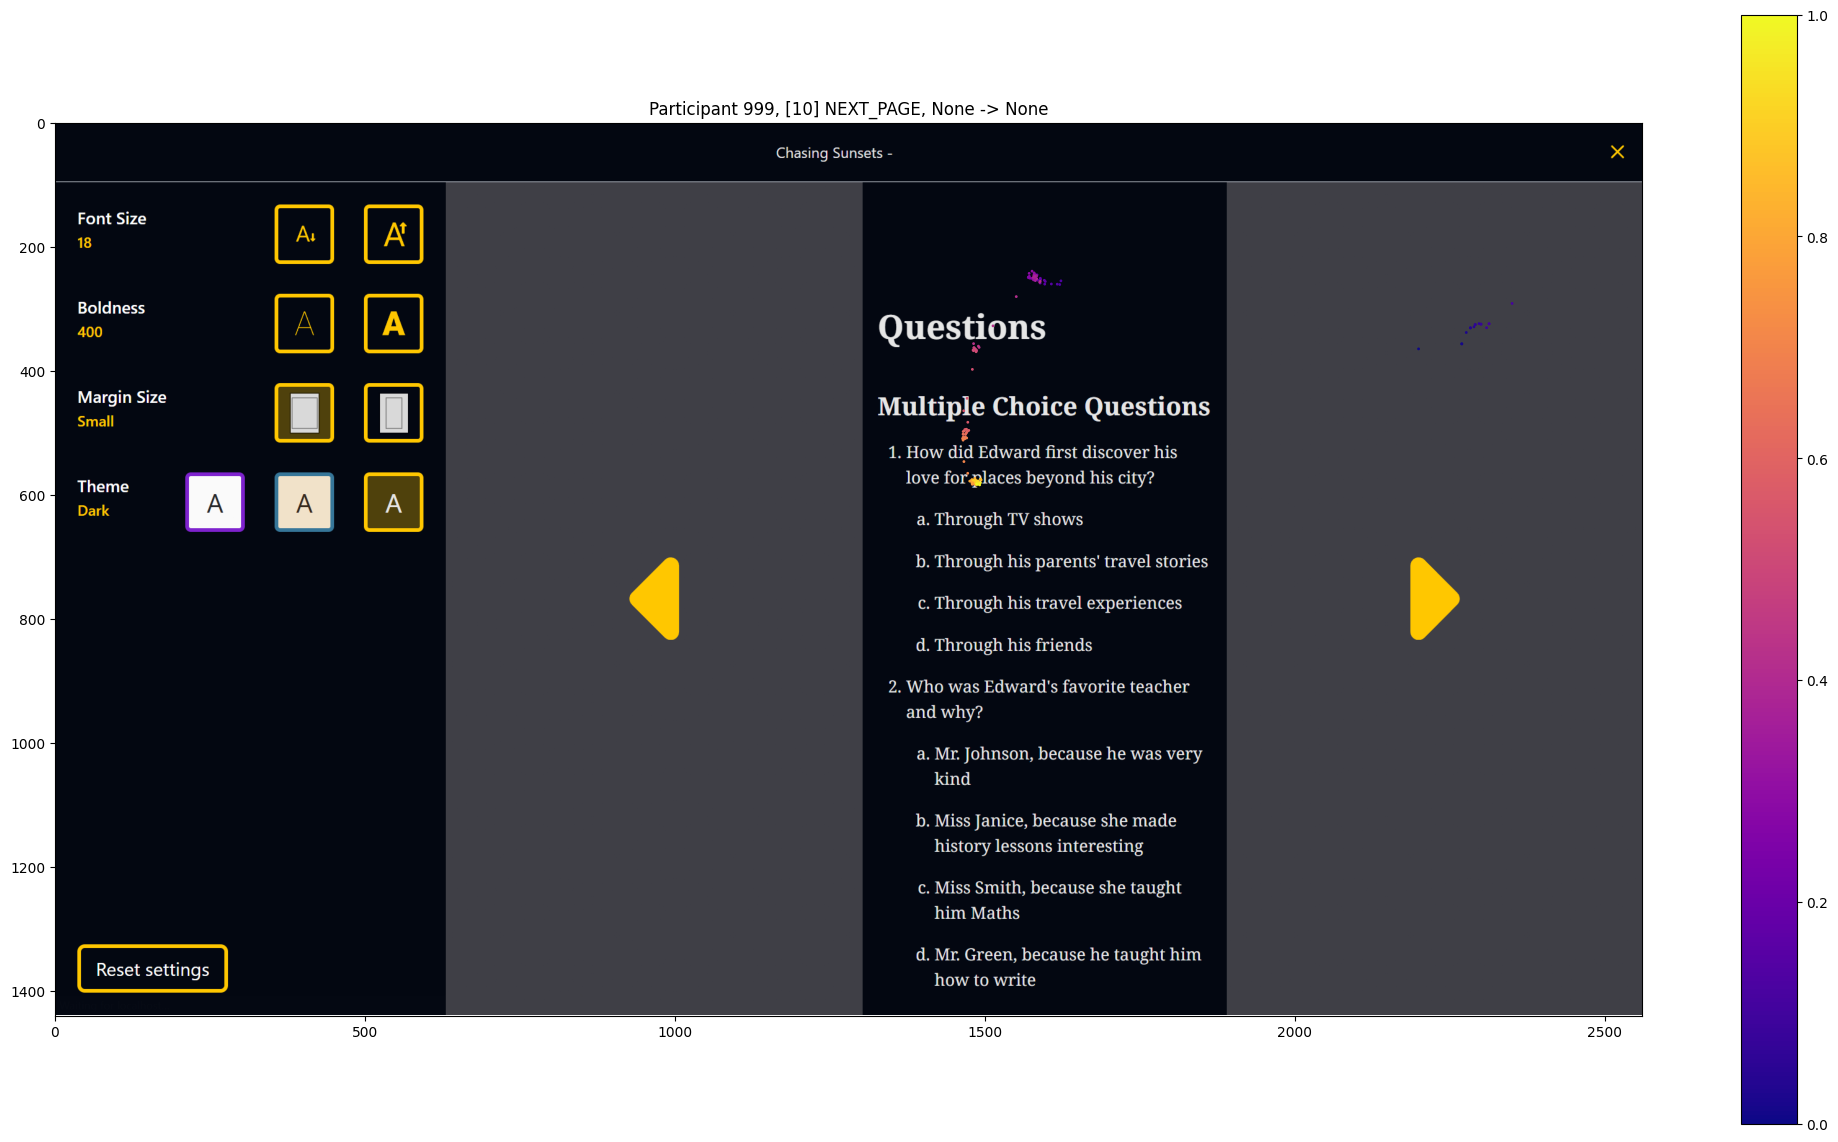

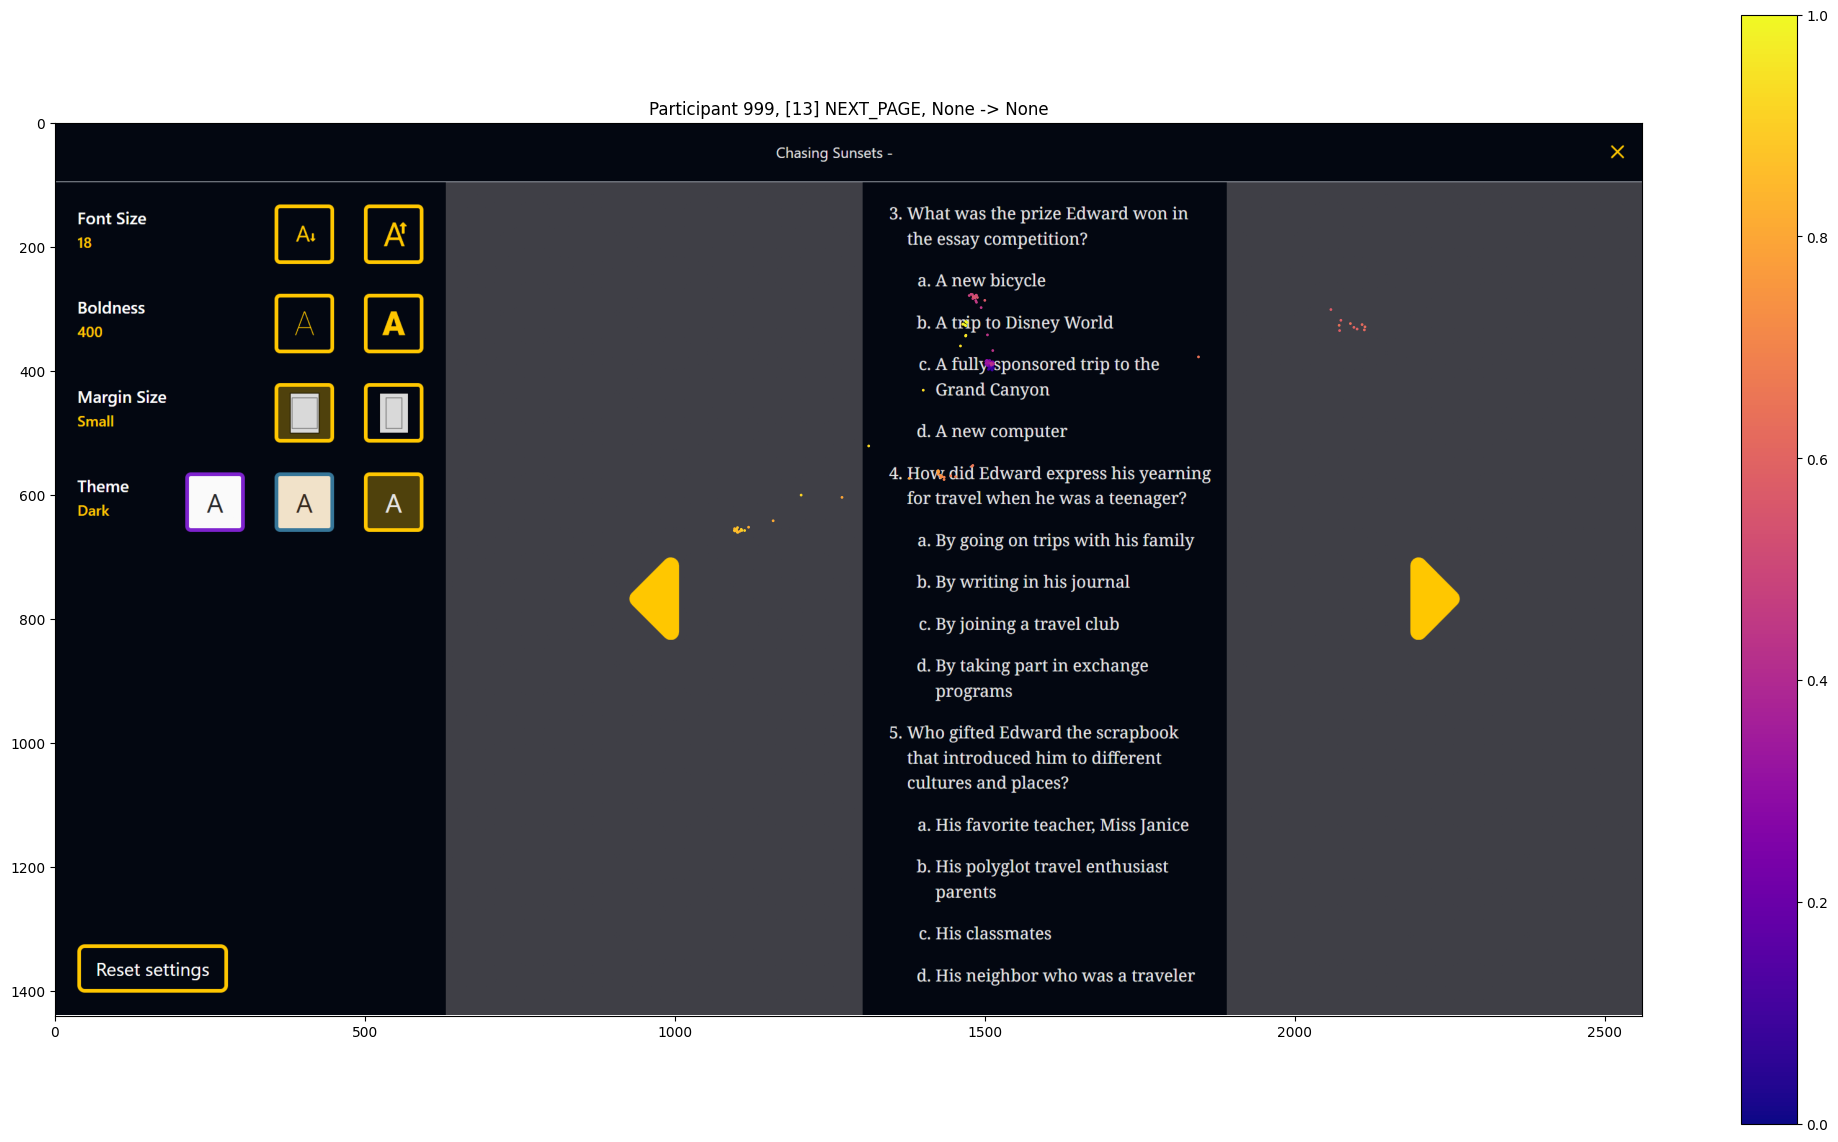

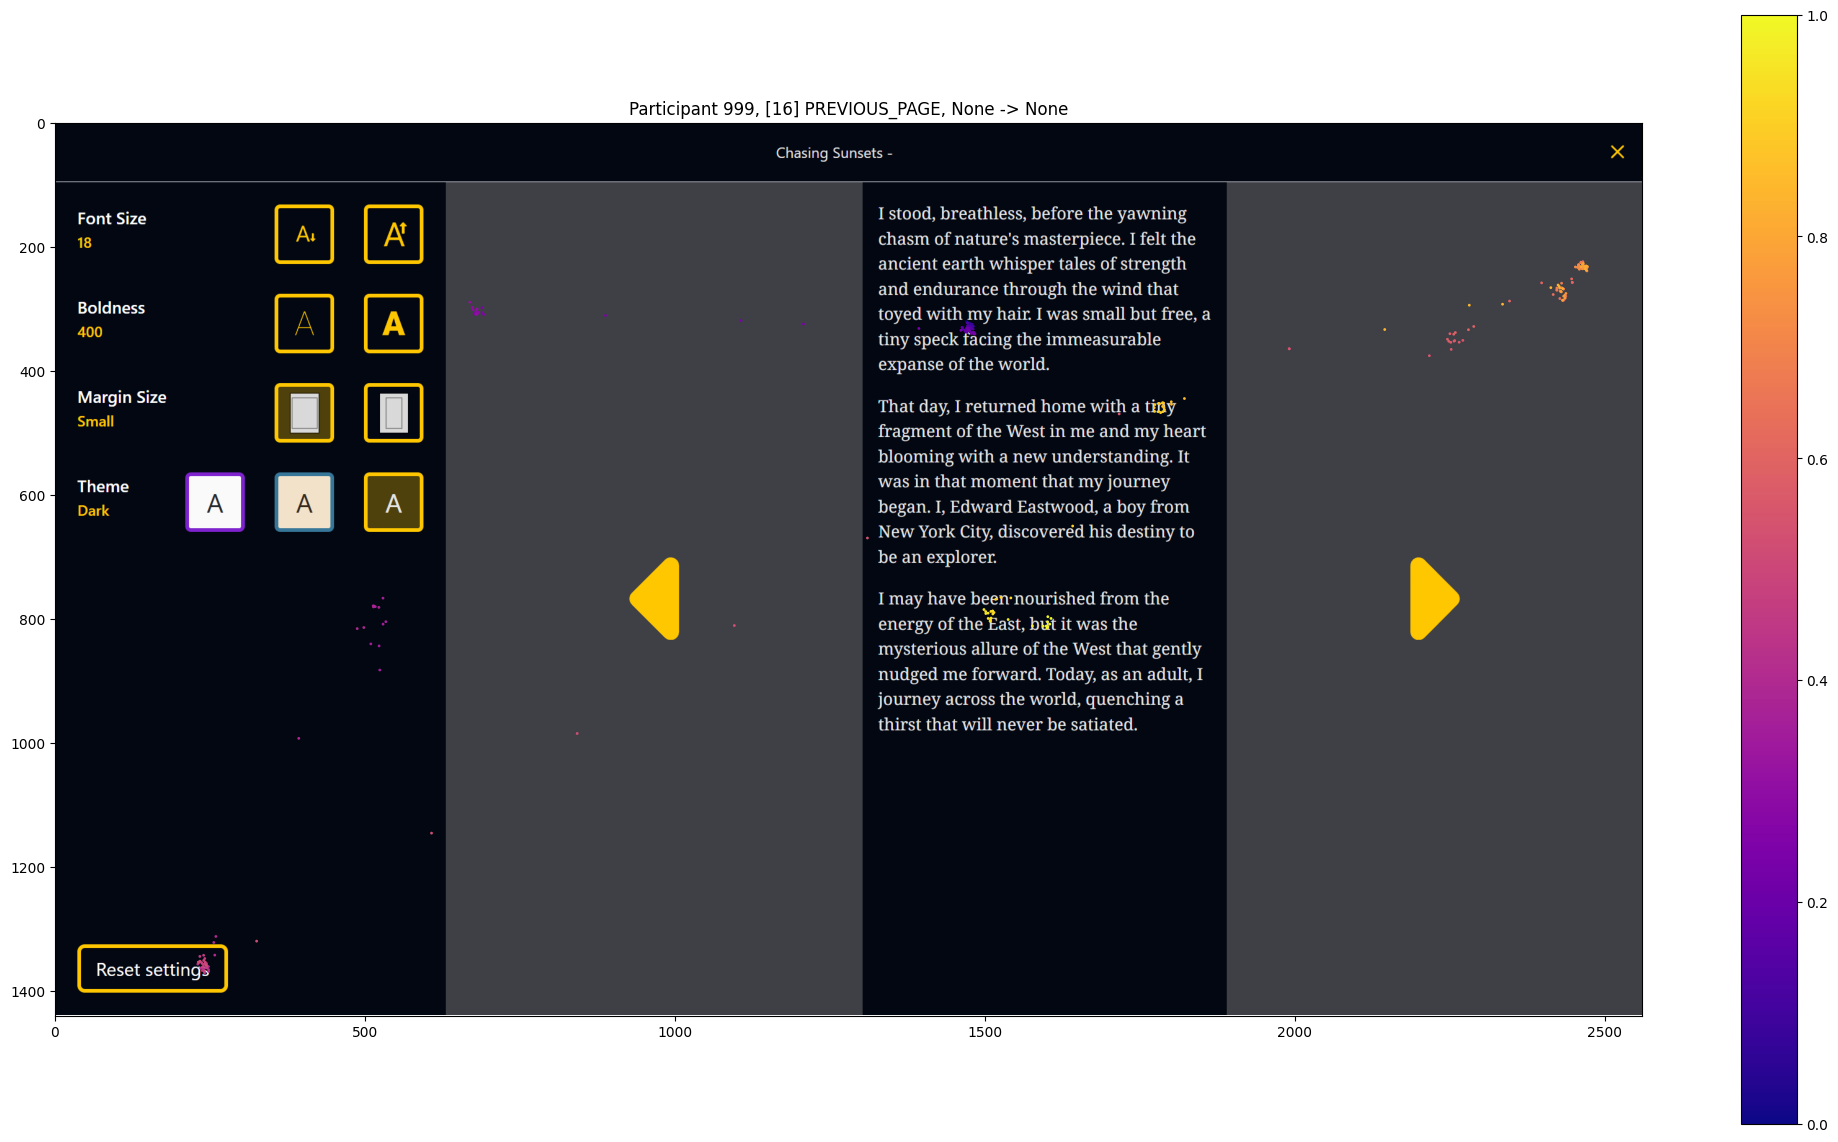

In [2]:
import os
from datetime import datetime

from utils import extract_gaze_data_between_timestamps_proper, plot_gaze_data_on_screenshot, print_record

# participants that were told that they can change the settings beforehand
participant_ids = [999]

# get the events
for participant in participant_ids:
  events = Events.select().where(Events.participant_id==participant)

  current_json_file = None
  batches_of_events = {}
  current_batch = []
  for event in events:
    if event.event == "SELECT_TREATMENT":
      continue
    elif event.event == "CLOSE_BOOK":
      current_batch.append(event)
      batches_of_events[current_json_file] = current_batch
      current_batch = []
    elif event.event == "OPEN_BOOK":
      timestamp = event.time
      date = datetime.fromtimestamp(timestamp / 1000)
      date_string = date.strftime("%Y-%m-%d_%H-%M-%S")
      current_json_file = f"[{participant}]-{date_string}.json"
      current_batch.append(event)
    else:
      current_batch.append(event)

  # for each json file, get the gaze data
  for json_file, events in batches_of_events.items():
    # get the gaze data for this participant
    # the files are in eye_tracker_data/
    path = "eye_tracker_data/"

    # for start_event in events:
    gaze_data_filename = json_file
    gaze_data_filepath = os.path.join(path, gaze_data_filename)
    # Read the file
    import json
    with open(gaze_data_filepath, "r") as f:
      gaze_data = json.load(f)

    pairs = list(zip(events, events[1:]))
    for begin_page_event, end_page_event in pairs:
      T_start = begin_page_event.time
      T_end = end_page_event.time

      # ignore the event if the participant only looked at this page for less than 5 seconds
      if T_end - T_start < 1_000:
        continue

      gaze_data_between_pageturn_events = extract_gaze_data_between_timestamps_proper(gaze_data, T_start, T_end)

      screenshot_path = begin_page_event.screenshot_file
      print_record(begin_page_event)
      plot_gaze_data_on_screenshot(gaze_data_between_pageturn_events, screenshot_path, title=f"Participant {participant}, [{begin_page_event.id}] {begin_page_event.event}, {begin_page_event.old_value} -> {begin_page_event.new_value}")
